## Data612 Project: Recommendation Movies Using Network Analysis

In this project, we attempt to recommend movies base on network analysis studies on nodes and edges.

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from collections import defaultdict
from nxviz import MatrixPlot, CircosPlot

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/AlainKuiete/DATA612ASSINGMENTS/master/ratings.csv")

In [3]:
#data = data.iloc[:100000,:]

In [4]:
data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
data.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [6]:
data['date'] = [datetime.fromtimestamp(d) for d in data['timestamp']]

In [7]:
data.head()

,userId,movieId,rating,timestamp,date
0,1,1,4.0,964982703,2000-07-30 14:45:03
1,1,3,4.0,964981247,2000-07-30 14:20:47
2,1,6,4.0,964982224,2000-07-30 14:37:04
3,1,47,5.0,964983815,2000-07-30 15:03:35
4,1,50,5.0,964982931,2000-07-30 14:48:51


In [8]:
data.userId = ['U'+str(n) for n in data.userId]
data.movieId = ['M'+str(n) for n in data.movieId]

In [9]:
min(data['date'])

Timestamp('1996-03-29 13:36:55')

In [10]:
max(data['date'])

Timestamp('2018-09-24 10:27:30')

#### Create a bipartite graph  with the degree centrality added to the metadata dictionary

In [11]:
# Instantiate a new Graph: G
G = nx.Graph()

# Add nodes from each of the partitions
G.add_nodes_from(data['userId'], bipartite = 'user')
G.add_nodes_from(data['movieId'], bipartite = 'movie')

# Add in each edge along with the rating as weight
for r, d in data.iterrows():
    G .add_edge(d['userId'], d['movieId'], weight=d['rating'])

In [12]:
# Add the date of each node to their metadata dictionary
dcs = nx.degree_centrality(G)
for n in G.nodes():
    G.nodes[n]['date'] = data['date']

In [13]:
# Add the degree centrality score of each node to their metadata dictionary
dcs = nx.degree_centrality(G)
for n in G.nodes():
    G.nodes[n]['centrality'] = dcs[n]

In [14]:
## Add the degree centrality score of each node to their metadata dictionary
#bwn = nx.betweenness_centrality(G)
#for n in G.nodes():
#    G.nodes[n]['betweenness'] = [bwn]

In [15]:
# Define get_nodes_from_partition()
def get_nodes_from_partition(T, partition):
    # Initialize an empty list for nodes to be returned
    nodes = []
    # Iterate over each node in the graph G
    for n in T.nodes():
        # Check that the node belongs to the particular partition
        if T.node[n]['bipartite'] == partition:
            # If so, append it to the list of nodes
            nodes.append(n)
    return nodes

# Print the number of nodes in the 'movies' partition
print(len(get_nodes_from_partition(G, 'movie')))

# Print the number of nodes in the 'users' partition
print(len(get_nodes_from_partition(G, 'user')))

9724
610


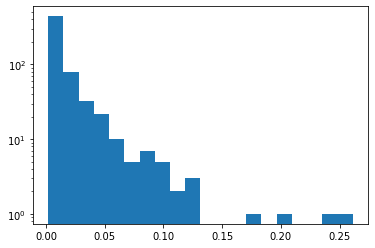

In [16]:
# Import matplotlib
import matplotlib.pyplot as plt

# Get the 'users' nodes: user_nodes
user_nodes = get_nodes_from_partition(G, 'user')

# Compute the degree centralities: dcs
dcs = nx.degree_centrality(G)

# Get the degree centralities for user_nodes: user_dcs
user_dcs = [dcs[n] for n in user_nodes]

# Plot the degree distribution of users_dcs
plt.yscale('log')
plt.hist(user_dcs, bins=20)
plt.show()


The distribution of degree centrality of users in this rating dataset is right skewed.

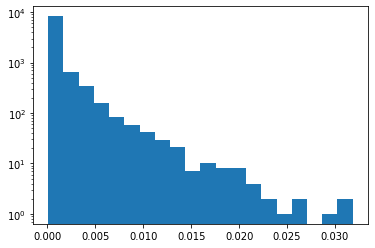

In [17]:
# Get the 'movies' nodes:
movie_nodes = get_nodes_from_partition(G, 'movie')

# Compute the degree centralities: dcs
dcs = nx.degree_centrality(G)

# Get the degree centralities for project_nodes: project_dcs
movie_dcs = [dcs[n] for n in movie_nodes]

# Plot the degree distribution of project_dcs
plt.yscale('log')
plt.hist(movie_dcs, bins=20)
plt.show()


The distribution of degree centrality of movies in this rating dataset is right skewed.

### Bipartite graphs and recommendation systems

#### Shared nodes in other partition
To build the recommendation systems, first, we compute user similarity in bipartite graphs.

We write a function that takes in two nodes, and returns the set of repository nodes that are shared between the two user nodes.


In [18]:
def shared_partition_nodes(G, node1, node2):
    # Check that the nodes belong to the same partition
    assert G.node[node1]['bipartite'] == G.node[node2]['bipartite']

    # Get neighbors of node 1: nbrs1
    nbrs1 = G.neighbors(node1)
    # Get neighbors of node 2: nbrs2
    nbrs2 = G.neighbors(node2)

    # Compute the overlap using set intersections
    overlap = set(nbrs1).intersection(nbrs2)
    return overlap

# Print the number of shared repositories between users 'u7909' and 'u2148'
print(len(shared_partition_nodes(G, 'U29', 'U2')))


5


#### User similarity metric
The next step is to write a function to compute the metric of similarity between two users: the number of ratings shared between two users divided by the total number of nodes in the other partition. This can then be used to find users that are similar to one another.

In [19]:
def user_similarity(G, user1, user2, movie_nodes):
    # Check that the nodes belong to the 'users' partition
    assert G.node[user1]['bipartite'] == 'user'
    assert G.node[user2]['bipartite'] == 'user'

    # Get the set of nodes shared between the two users
    shared_nodes = shared_partition_nodes(G, user1, user2)

    # Return the fraction of nodes in the projects partition
    return len(shared_nodes) / len(G.nodes(movie_nodes))

# Compute the similarity score between users 'u4560' and 'u1880'
movie_nodes = get_nodes_from_partition(G, 'movie')
similarity_score = user_similarity(G, 'U7', 'U29', 'movie')

print(similarity_score)


0.0013547513063673312


#### Find similar users
We write a function called most_similar_users() that finds the users most similar to another given user.

In [20]:
from collections import defaultdict

def most_similar_users(G, user, user_nodes, movie_nodes):
    # Data checks
    assert G.node[user]['bipartite'] == 'user'

    # Get other nodes from user partition
    user_nodes = set(user_nodes)
    user_nodes.remove(user)

    # Create the dictionary: similarities
    similarities = defaultdict(list)
    for n in user_nodes:
        similarity = user_similarity(G, user, n, movie_nodes)
        similarities[similarity].append(n)

    # Compute maximum similarity score: max_similarity
    max_similarity = max(similarities.keys())

    # Return list of users that share maximal similarity
    return similarities[max_similarity]

user_nodes = get_nodes_from_partition(G, 'user')
movie_nodes = get_nodes_from_partition(G, 'movie')

print(most_similar_users(G, 'U7', user_nodes, movie_nodes))


['U414']


#### Recommend repositories
We're going to use the set differences to get recommendation for a second user from similarities with the first users.

In [21]:
def recommend_repositories(G, from_user, to_user):
    # Get the set of repositories that from_user has contributed to
    from_repos = set(G.neighbors(from_user))
    # Get the set of repositories that to_user has contributed to
    to_repos = set(G.neighbors(to_user))

    # Identify repositories that the from_user is connected to that the to_user is not connected to
    return from_repos.difference(to_repos)

# Print the repositories to be recommended
print(recommend_repositories(G, 'U29', 'U2'))


{'M1792', 'M165', 'M170', 'M1204', 'M1262', 'M1208', 'M750', 'M4327', 'M55820', 'M1201', 'M1408', 'M1198', 'M1242', 'M1945', 'M858', 'M26554', 'M68237', 'M87306', 'M1272', 'M5995', 'M82459', 'M111362', 'M5010', 'M1213', 'M2951', 'M4980', 'M1939', 'M924', 'M2872', 'M150', 'M356', 'M64620', 'M7379', 'M2301', 'M1270', 'M56174', 'M6787', 'M1222', 'M1772', 'M2028', 'M1385', 'M1136', 'M1250', 'M1303', 'M26729', 'M4223', 'M780', 'M27611', 'M3591', 'M48774', 'M914', 'M953', 'M70286', 'M2944', 'M1209', 'M296', 'M2761', 'M81845', 'M111759', 'M1224', 'M5464', 'M7156', 'M51540', 'M50', 'M904', 'M3441', 'M1617', 'M87232', 'M104841', 'M3681', 'M98961', 'M3363', 'M316', 'M1100', 'M2420', 'M6502'}


In [22]:
data_movie = pd.read_csv("https://raw.githubusercontent.com/AlainKuiete/DATA612ASSINGMENTS/master/movies.csv")

In [23]:

data_movie.movieId = ['M'+str(n) for n in data_movie.movieId]


In [24]:
m_dict = {}
M = data_movie['movieId']
T = data_movie['title']
for n in range(len(M)):
    m_dict[M[n]] = T[n]

In [25]:
top_repo = [m for m in recommend_repositories(G, 'U29', 'U2') if G.nodes[m]['centrality']>=.01]

In [26]:
recommended_repo = []
for Mid in top_repo:
    recommended_repo.append(m_dict[Mid])
print(recommended_repo)

['Die Hard: With a Vengeance (1995)', 'Apocalypse Now (1979)', 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', 'Godfather, The (1972)', 'Goodfellas (1990)', '2001: A Space Odyssey (1968)', 'Apollo 13 (1995)', 'Forrest Gump (1994)', 'Back to the Future (1985)', 'Saving Private Ryan (1998)', 'Monty Python and the Holy Grail (1975)', 'Independence Day (a.k.a. ID4) (1996)', 'Pulp Fiction (1994)', 'Usual Suspects, The (1995)', 'Stargate (1994)']


In [27]:
def compute_graph_metrics(g):
    """Computes the basic node and edge counts as well as degree centrality measures"""
    node_cnt = g.number_of_nodes()
    edge_cnt = len(g.edges())
    degrees = sorted([len(list(g.neighbors(n)))for n in g.nodes() ]) 
    
    return dict(
    node_cnt = node_cnt,
    edge_cnt = edge_cnt,
    avg_degree = sum(degrees)/len(degrees),
    min_degree = degrees[0],
    max_degree = degrees[-1],
    )

In [28]:
def trim_edges(g, weight=1): 
    """
    Trims the edges based on edge weight
    Source: M. Tsvetovat, A. Kouznetsov (2011), Social Network Analysis for Startups 
    """
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True): 
        if edata['weight'] > weight:
            g2.add_edge(f,to,weight = edata['weight'])
    return g2

In [29]:
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations 
    
    step=int((mx-mn)/iterations)
    if step ==0:
        step = 1
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]


In [30]:
# Import necessary modules
from itertools import combinations
from collections import defaultdict

# Initialize the defaultdict: recommended
recommended = defaultdict(int)

# Iterate over all the nodes in G
for n, d in G.nodes(data=True):

    # Iterate over all possible triangle relationship combinations
    for n1, n2 in combinations(G.neighbors(n), 2):

        # Check whether n1 and n2 do not have an edge
        if not G.has_edge(n1, n2):

            # Increment recommended
            recommended[(n1, n2)] += 1

# Identify the top 10 pairs of users
all_counts = sorted(recommended.values())
top10_pairs = [pair for pair, count  in recommended.items() if count > all_counts[-10]]
print(top10_pairs)


[('U68', 'U414'), ('U68', 'U599'), ('U274', 'U414'), ('U274', 'U599'), ('U414', 'U448'), ('U414', 'U474'), ('U414', 'U599'), ('U448', 'U599'), ('U474', 'U599')]


Given the large number of edges, and the fact that each user has rated at least 20 films, we will limit the bipartite graph only to the edges with a rating score of 5 (the highest rating), so as to focus on the movies the users liked. This would enable us to build a clearer picture of association between movies based on user ratings and of users based on shared movie preferences.


In [31]:
#from networkx.algorithms import bipartite
high_rating = [(u,v,d) for (u,v,d) in G.edges(data=True) if d["weight"]==5]
G_filtered = nx.Graph(high_rating)

In [32]:
user_nodes_filt = [n for n, d in G_filtered.nodes(data=True) if n.startswith("U")]

In [33]:
movie_nodes_filt = [n for n, d in G_filtered.nodes(data=True) if n.startswith("M")]

In [34]:

print("""The filtered graph contains: {} nodes, out of which: 
    {} are user nodes, 
    {} are movie nodes.
The graph has {} edges in total.
""".format(len(G_filtered.nodes()),len(user_nodes_filt),len(movie_nodes_filt),len(G_filtered.edges())))

The filtered graph contains: 3527 nodes, out of which: 
    573 are user nodes, 
    2954 are movie nodes.
The graph has 13211 edges in total.



We can see that while the number of users has decreased insignificantly, the number of edges to consider has been reduced to a quarter of the the original value. Now we can proceed to projecting the graphs into the space of movies and users.
3. Investigate the affiliation between movies
We will project the graph onto movie nodes building an edge between two movies every time a user has provided a positive rating (from our filtered bipartite graph) to both of them. This way, movies that get positive reviews from multiple users should become connected with each other.
The weight of the edge between two movies will equal the number of users who gave a positive rating to both of the movies.



In [35]:
M = nx.bipartite.weighted_projected_graph(G_filtered, movie_nodes_filt)
compute_graph_metrics(M)

{'node_cnt': 2954,
 'edge_cnt': 298586,
 'avg_degree': 202.1570751523358,
 'min_degree': 0,
 'max_degree': 1776}

As displayed above, the graph of movies has a very large number of edges due to the many combinations of users and movies they have reviewed.
It would make sense to only focus on the edges (representing movie similarity) that have been validated by at least n users.

We can then focus on the largest connected component, and separate it further using the island method described in the course book to identify the most affiliated movies.


In [36]:
# Identify the threshold for the more validated edges
M_weights = [d["weight"] for (u,v,d) in M.edges(data=True)] # weight = number of users who rated both movies
M_weights = np.array(M_weights)
quantiles = [0,25,50,75,100]
M_weights_pct = dict(zip(quantiles,list(np.percentile(M_weights, quantiles))))
print( M_weights_pct)

{0: 1.0, 25: 1.0, 50: 1.0, 75: 1.0, 100: 62.0}


We can see that only 50% of movies have at least two shared users, and 25% have more than five. We will focus the subset with at least five shared positive ratings, as such observations are more valid.

In [37]:
M_trimmed = trim_edges(M, weight=4)


In [38]:
# Reduce the size using the island method
M_cc = list(nx.connected_component_subgraphs(M_trimmed))[0] # extract the largest connected component
islands = island_method(M_cc, iterations=8)
for i in islands:
    # print the threshold level, size of the graph, and number of connected components ... 
    print(i[0], len(i[1]), len(list(nx.connected_component_subgraphs(i[1]))))

5 376 1
12 99 1
19 45 1
26 27 1
33 19 2
40 16 2
47 6 2
54 4 2
61 2 1


We can see that all the movies seem to be well-connected, and trimming at various levels only provides two separate components at the threshold of 5 leaving 81 nodes in total. We pick this threshold level to visualize the structure:


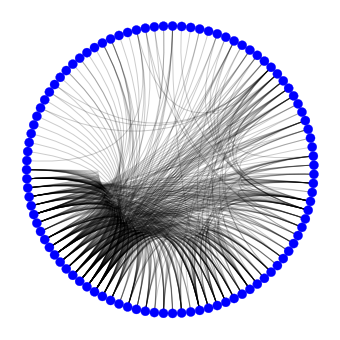

In [39]:
m_result = islands[1][1]
# Create the CircosPlot object
c = CircosPlot(graph=m_result)
# Draw c
c.draw()
# Display
plt.show()

In [40]:
# Read the names of the movies
with open("https://raw.githubusercontent.com/AlainKuiete/DATA612ASSINGMENTS/master/movies.csv") as f:
    inp_movies = f.readlines()
    inp_movies = [item.strip().split(',') for item in inp_movies]
    # Add user and movie id modifiers and drop the timestamps
    inp_movies = [['M'+item[0], item[1], item[2]] for item in inp_movies] # adjust the ids
    inp_movies = dict([(item[0],item[1]) for item in inp_movies]) # convert to dict

In [41]:
# Add titles to the movies in the result graph
for i in m_result.nodes():
    m_result.node[i]["title"] =  inp_movies[i]

net.write_gexf(m_result,"m_result.gexf")


Now we can:
1. visually inspect the relationships between the movies in the resulting graph
2. get the popularity ranking of the movies in the resulting graph

First, we'll investigate the two connected components in the graph.

In [42]:
nx.write_gexf(m_result,"m_result.gexf")

The island method has returned two components: a small one containing two films, and a large one, containing the rest.

In [43]:
movies_small = max(nx.connected_component_subgraphs(m_result), key=len)
movies_large = max(nx.connected_component_subgraphs(m_result),key=len)

In [44]:
min(nx.connected_component_subgraphs(m_result), key=len)

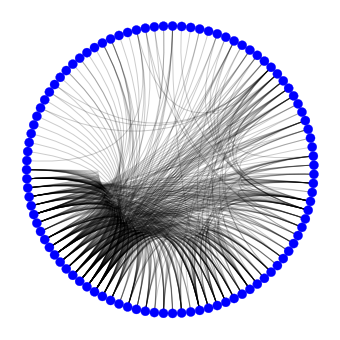

In [45]:
# Create the CircosPlot object
c = CircosPlot(graph=movies_small)
# Draw c
c.draw()
# Display
plt.show()

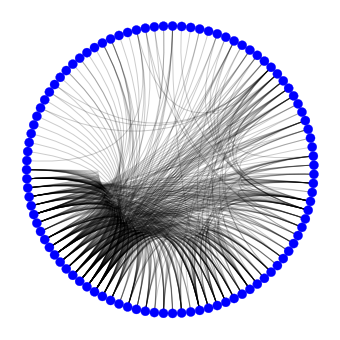

In [46]:
# Create the CircosPlot object
c = CircosPlot(graph=movies_large)
# Draw c
c.draw()
# Display
plt.show()

#### Below is a top-10 list of movies by descending weighted degree centrality:

In [47]:
m_l_deg = movies_large.degree(weight="weight")
m_l_top10 = sorted(m_l_deg, key=lambda x: x[1],reverse=True)[:10]
for item in m_l_top10: 
    print(inp_movies[item[0]]) 

Pulp Fiction (1994)
"Shawshank Redemption
"Matrix
Star Wars: Episode IV - A New Hope (1977)
"Godfather
Star Wars: Episode V - The Empire Strikes Back (1980)
Forrest Gump (1994)
Fight Club (1999)
"Silence of the Lambs
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)


In [48]:
m_l_edgewt = nx.get_edge_attributes(movies_large,"weight").items()
m_l_top10_edges = sorted(m_l_edgewt, key=lambda x: x[1],reverse=True)[:10]
for item in m_l_top10_edges: 
    print(inp_movies[item[0][0]] + " - " + inp_movies[item[0][1]])

Star Wars: Episode V - The Empire Strikes Back (1980) - Star Wars: Episode IV - A New Hope (1977)
"Shawshank Redemption - Pulp Fiction (1994)
Star Wars: Episode VI - Return of the Jedi (1983) - Star Wars: Episode IV - A New Hope (1977)
"Shawshank Redemption - Forrest Gump (1994)
Star Wars: Episode V - The Empire Strikes Back (1980) - Star Wars: Episode VI - Return of the Jedi (1983)
Fight Club (1999) - "Matrix
"Shawshank Redemption - Schindler's List (1993)
"Matrix - Star Wars: Episode IV - A New Hope (1977)
"Lord of the Rings: The Return of the King - "Lord of the Rings: The Fellowship of the Ring
"Silence of the Lambs - Pulp Fiction (1994)


4. Investigate the affiliation between users
Now we will project our filtered bipartite graph onto user nodes building an edge between two users every time they have rated the same movie positively. This way, users that have similar likes will be tied together. The weight of the edge between two users will equal the number of movies they both rated positively, thus indicating a strength of the match between individual movie tastes.
After the user graph is built, we can investigate connected components within it to see if any distinct groups of users can be discerned.

In [49]:
U = nx.bipartite.weighted_projected_graph(G_filtered, user_nodes_filt)
compute_graph_metrics(U)


{'node_cnt': 573,
 'edge_cnt': 61796,
 'avg_degree': 215.69284467713788,
 'min_degree': 0,
 'max_degree': 508}

In [50]:
# Identify the threshold for the more validated edges
U_weights = [d["weight"] for (u,v,d) in U.edges(data=True)] # weight = number of users who rated both movies
U_weights = np.array(U_weights)
quantiles = [0,25,50,75,100]
U_weights_pct = dict(zip(quantiles,list(np.percentile(U_weights, quantiles))))
print(U_weights_pct)

{0: 1.0, 25: 1.0, 50: 2.0, 75: 3.0, 100: 62.0}


We can see that only 50% of users have at least two shared movies, and 75% five or more. We will focus the subset with at least ten shared positively rated movies, as such observations are more valid for judging the similarity in the taste between users.


In [51]:
# Exclude the edges with the weight above the treshold
U_trimmed = trim_edges(U, weight=9)

In [52]:
# Reduce the size using the island method
U_ccs = list(nx.connected_component_subgraphs(U_trimmed)) # all connected components
U_cc = U_ccs[0] # extract the largest connected component
# Inspect the connected components
len(U_ccs)

1

We see that after the edge trimming, a single large connected component remains with approx. 1 mln. edges among 4347 users. Now we can try to break it into groups using the island method:


In [53]:
islands1 = island_method(U_cc, iterations=8)
for i in islands1:
    # print the threshold level, size of the graph, and number of connected components ... 
    print(i[0], len(i[1]), len(list(nx.connected_component_subgraphs(i[1]))))

10 169 1
16 88 1
22 44 1
28 24 1
34 18 1
40 9 1
46 6 1
52 4 1
58 4 2


We can see that all the users seem to be well-connected, and trimming at various levels only provides a single component at all levels. We will pick the degree level of 16 leaving 88 users with higher number of jointly rated movies to visualize the structure:


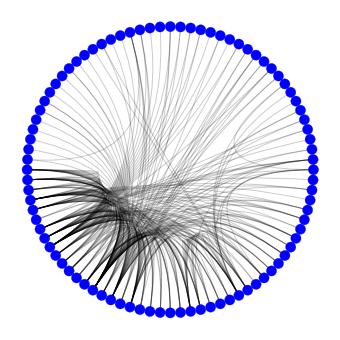

In [54]:
u_result = islands1[1][1]
# Create the CircosPlot object
c = CircosPlot(graph=u_result)
# Draw c
c.draw()
# Display
plt.show()


### Time Series Analysis

New graph

In [55]:
# Instantiate a new Graph: G
T = nx.Graph()

# Add nodes from each of the partitions
T.add_nodes_from(data['userId'], bipartite = 'user')
T.add_nodes_from(data['movieId'], bipartite = 'movie')

# Add in each edge along with the rating as weight
for r, d in data.iterrows():
    T .add_edge(d['userId'], d['movieId'], date = d['date'])

#### Plot number of ratings being made over time

1996-11-01 13:36:55
1997-08-01 13:36:55
1998-05-01 13:36:55
1999-01-01 13:36:55
1999-10-01 13:36:55
2000-09-01 13:36:55
2000-12-01 13:36:55
2001-06-01 13:36:55
2002-02-01 13:36:55
2002-03-01 13:36:55
2002-11-01 13:36:55
2003-08-01 13:36:55
2004-10-01 13:36:55
2005-04-01 13:36:55
2005-07-01 13:36:55
2006-09-01 13:36:55
2006-12-01 13:36:55
2007-06-01 13:36:55
2008-02-01 13:36:55
2008-08-01 13:36:55
2009-05-01 13:36:55
2010-01-01 13:36:55
2010-10-01 13:36:55
2011-04-01 13:36:55
2011-07-01 13:36:55
2012-06-01 13:36:55
2013-02-01 13:36:55
2013-03-01 13:36:55
2013-11-01 13:36:55
2014-08-01 13:36:55
2015-05-01 13:36:55
2016-01-01 13:36:55
2016-04-01 13:36:55
2016-07-01 13:36:55
2017-09-01 13:36:55
2017-12-01 13:36:55
2018-06-01 13:36:55


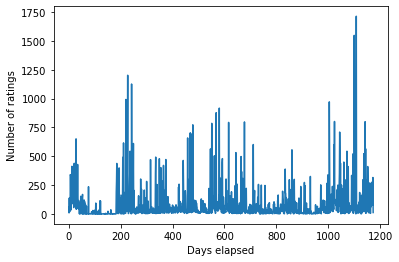

In [56]:
# Define current day and timedelta of 2 days
dayone = min(data['date'])
lastday = max(data['date'])
curr_day = dayone
td = timedelta(7)

# Initialize an empty list of posts by day
n_posts = []
while curr_day < lastday:
    if curr_day.day == 1:
        print(curr_day) 
    # Filter edges such that they are within the sliding time window: edges
    edges = [(u, v, d) for u, v, d in T.edges(data=True) if d['date'] >= curr_day and d['date'] < curr_day + td]
    
    # Append number of edges to the n_posts list
    n_posts.append(len(edges))
    
    # Increment the curr_day by the time delta
    curr_day += td
    
# Create the plot
plt.plot(n_posts)  
plt.xlabel('Days elapsed')
plt.ylabel('Number of ratings')
plt.show()  


#### Extract the mean degree centrality day-by-day on the users partition
Here, you're going to see if the mean degree centrality over all nodes is correlated with the number of edges that are plotted over time.

1996-11-01 13:36:55
1997-08-01 13:36:55
1998-05-01 13:36:55
1999-01-01 13:36:55
1999-10-01 13:36:55
2000-09-01 13:36:55
2000-12-01 13:36:55
2001-06-01 13:36:55
2002-02-01 13:36:55
2002-03-01 13:36:55
2002-11-01 13:36:55
2003-08-01 13:36:55
2004-10-01 13:36:55
2005-04-01 13:36:55
2005-07-01 13:36:55
2006-09-01 13:36:55
2006-12-01 13:36:55
2007-06-01 13:36:55
2008-02-01 13:36:55
2008-08-01 13:36:55
2009-05-01 13:36:55
2010-01-01 13:36:55
2010-10-01 13:36:55
2011-04-01 13:36:55
2011-07-01 13:36:55
2012-06-01 13:36:55
2013-02-01 13:36:55
2013-03-01 13:36:55
2013-11-01 13:36:55
2014-08-01 13:36:55
2015-05-01 13:36:55
2016-01-01 13:36:55
2016-04-01 13:36:55
2016-07-01 13:36:55
2017-09-01 13:36:55
2017-12-01 13:36:55
2018-06-01 13:36:55


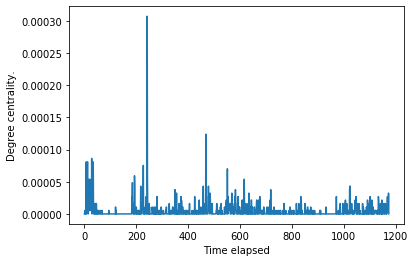

In [57]:
# Initialize a new list: mean_dcs
mean_dcs = []
curr_day = dayone
td = timedelta(days=7)

user_nodes = user_nodes = get_nodes_from_partition(T, 'user')

while curr_day < lastday:
    if curr_day.day == 1:
        print(curr_day)  
    # Instantiate a new graph containing a subset of edges: G_sub
    T_sub = nx.Graph()
    # Add nodes from G
    T_sub.add_nodes_from(T.nodes(data=True))
    # Add in edges that fulfill the criteria
    T_sub.add_edges_from([(u, v, d) for u, v, d in T.edges(data=True) if d['date'] >= curr_day and d['date'] < curr_day + td])
    
    # Get the students projection
    T_user_sub = nx.bipartite.projected_graph(T_sub, user_nodes)
    # Compute the degree centrality of the students projection
    dc = nx.degree_centrality(T_user_sub)
    # Append mean degree centrality to the list mean_dcs
    mean_dcs.append(np.mean(list(dc.values())))
    # Increment the time
    curr_day += td
    
plt.plot(mean_dcs)
plt.xlabel('Time elapsed')
plt.ylabel('Degree centrality.')
plt.show()

It appear that there is no correlation between the number of ratings day by day and the degree centrality.

#### Find the most popular movies day-by-day

1997-08-01 13:36:55
1999-01-01 13:36:55
2000-12-01 13:36:55
2001-06-01 13:36:55
2002-11-01 13:36:55
2004-10-01 13:36:55
2005-04-01 13:36:55
2006-09-01 13:36:55
2008-02-01 13:36:55
2008-08-01 13:36:55
2010-01-01 13:36:55
2011-07-01 13:36:55
2012-06-01 13:36:55
2013-11-01 13:36:55
2015-05-01 13:36:55
2016-04-01 13:36:55
2017-09-01 13:36:55


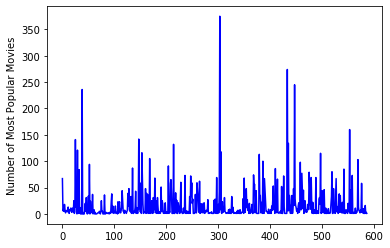

In [59]:
most_popular_movies = []
highest_dcs = []
curr_day = dayone 
td = timedelta(days=14)  

while curr_day < lastday:  
    if curr_day.day == 1:  
        print(curr_day)  
    T_sub = nx.Graph()
    T_sub.add_nodes_from(T.nodes(data=True))   
    T_sub.add_edges_from([(u, v, d) for u, v, d in T.edges(data=True) if d['date'] >= curr_day and d['date'] < curr_day + td])
    
    # Get the degree centrality 
    dc = nx.bipartite.degree_centrality(T_sub, movie_nodes)
    # Filter the dictionary such that there's only movie degree centralities
    movie_dcs = {n:dc for n, dc in dc.items() if n in movie_nodes}
    # Identify the most popular forum(s) 
    most_popular_movie = [n for n, dc in movie_dcs.items() if dc == max(movie_dcs.values()) and dc != 0] 
    most_popular_movies.append(most_popular_movie) 
    # Store the highest dc values in highest_dcs
    highest_dcs.append(max(movie_dcs.values()))
    
    curr_day += td  
    
plt.figure(1) 
plt.plot([len(movies) for movies in most_popular_movies], color='blue', label='Movies')
plt.ylabel('Number of Most Popular Movies')
plt.show()


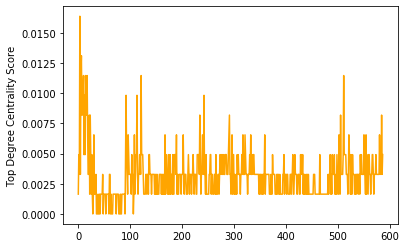

In [60]:
plt.figure(2)
plt.plot(highest_dcs, color='orange', label='DC Score')
plt.ylabel('Top Degree Centrality Score')
plt.show()


#### References
1. Project 2: Movie and User Similarity in the MovieLens Dataset
By Dmitriy Vecheruk
2. Intermediate Network Analysis in Python
By Eric Ma, DataCamp